In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # on NERSC filelocking is not allowed
import h5py
import tensorflow as tf
# Make notebook run on other GPUS. GPT's solution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# gpus = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(gpus[2], 'GPU')  # change 1 to 0, 2, 3 as needed
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import tensorflow.keras as keras
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk


import sys
# Path to dir model.py lives in -------
# NOTE: This needs to be modified to where your repo lives, path to /repo/path/VAE_FS/models/
# If the jupyter notebook kernel is running from VAE_FS/models/ the
# line below is not needed
sys.path.append('/global/homes/j/jananinf/projs/VAE_FS/models/')

# import the custom models and functions
from models import VAE_Model, Qmake_encoder_set_weights, Qmake_decoder_set_weights

2025-07-10 11:09:25.342119: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-10 11:09:27.053039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# helper functions. These are intended as the AD metric funciton in calc_anomaly_scores
def AD_score_KL(z_mean, z_log_var):
    kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    # Comparing this to eq 2 in arXiv: 2108.03986 z_log_var = log(sigma**2)
    return kl_loss


def AD_score_CKL(z_mean, _): # z_log_var not used
    CKL = np.mean(z_mean**2)
    return CKL 


def calc_anomaly_scores(data, encoder: keras.Model, AD_metric, debug = True):
    """
    Parameters:
    -----------
    debug: Optional bool to skip latent space vectors that produce infinities.
    Currently set to true as it seems only 2 specific cases are affected
    """
    dat_encoded = np.array(encoder.predict(data))[0] # This outputs shape (3, len(X_test), 3). Can't find satisfactory explanation for this behavior. (len(X_test), 3) makes sense. (3, len, 3) does not
    # Kenny only uses the first list so we'll follow that convention.
    # has shape (len(data), 3), where col 1 is z_mean, 2 is z_log_var and z. This is by design of encoder.
    scores = np.zeros(len(data))
    for i in range(len(scores)):
        z_mean, z_log_var = dat_encoded[i][0], dat_encoded[i][1]
        score = AD_metric(z_mean, z_log_var)
        # This is problematic when calculating the ROC curve.
        if debug and (score == np.inf):
            print("RUNTIME WARNING: inf encountered. Skipping these values\n"
                  + f"z_mean: {z_mean}\n"
                  + f"z_log_var: {z_log_var}")
            continue
        scores[i] = score

    return scores


def get_truth_and_scores(encoder, AD_metric, debug=True):
    bg_score = calc_anomaly_scores(X_test, encoder, AD_metric)
    scores = []
    truths = []
    zeros = np.zeros(len(X_test))
    signal_data = [leptoquark_data, Ato4l_data, hChToTauNu_data, hToTauTau_data]

    # Generate Truth and score lists ready for ROC curve calculation
    for dat in signal_data:
        truths.append(np.concatenate((zeros, np.ones(len(dat)))))

        s = calc_anomaly_scores(dat, encoder, AD_metric, debug=debug)
        scores.append(np.concatenate((bg_score,s) ))

    return (truths, scores)
def plot_rocs(truths, scores, fig_title):
    target_fpr = 1e-5
    tpr_at_target = []
    signal_names_tex = [ # latex version
                    "Leptoquark"
                    , "$A\\rightarrow 4\ell$"
                    , "$h^{\pm}\\rightarrow\\tau \\nu$"
                    , "$h^0\\rightarrow\\tau\\tau$"
                    ]
    signal_names_hum = [ # human readable
                    "Leptoquark"
                    ,"A to 4L"
                    , "h to Tau Nu"
                    , "h to Tau Tau"
                    ]

    for truth, score, l in zip(truths, scores, signal_names_tex):
        fpr, tpr, thresholds = roc_curve(truth, score)
        auc = sk.roc_auc_score(truth, score)
        plt.plot(fpr, tpr, label=l + f": {str(round(auc, 3))}") # plot roc curve



        # Find tpr at fpr target
        idx = np.argmin(np.abs(fpr - target_fpr))
        tpr_at_target.append(tpr[idx])
        
    plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--")
    plt.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")

    # Plot teaks
    plt.loglog()
    plt.legend()
    plt.grid()
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title(fig_title) 
    plt.show()

    for sig_nam, tpr in zip(signal_names_hum, tpr_at_target):
        print(sig_nam + " TPR @ FPR 10e-5 (%): " + f"{tpr*100:.2f}")
    

In [3]:
# Load data
home_path = "/global/cfs/cdirs/m2616/jananinf/projsIO/VAE_FS/" # Updated to NERSC
file_path = home_path + "preprocessed_SNL_data.h5"
with h5py.File(file_path, 'r') as hf:           # Shapes:
    X_train = hf['X_train'][:]                  # (3200000, 57)
    X_test  = hf['X_test'][:]                   # (800000,  57)
    Ato4l_data  = hf['Ato4l_data'][:]           # (55969,   57) Signal data? 
    hToTauTau_data  = hf['hToTauTau_data'][:]   # (691283,  57)
    hChToTauNu_data  = hf['hChToTauNu_data'][:] # (760272,  57)
    leptoquark_data = hf['leptoquark_data'][:]  # (340544,  57)
    print("Data loaded from preprocessed_SNL_data.h5")

Data loaded from preprocessed_SNL_data.h5


##### We will now search for the best performing model. 

10642/10642 [==============================] - 7s 616us/step


/tmp/ipykernel_93483/609871311.py:3: RuntimeWarning: overflow encountered in exp
  kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))


RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -60.02294921875
z_log_var: 91.490478515625
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -79.36632537841797
z_log_var: 109.4120864868164
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -40.54600524902344
z_log_var: 114.4395980834961
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -30.750242233276367
z_log_var: 90.95156860351562
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -44.372676849365234
z_log_var: 102.86420440673828
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -20.678930282592773
z_log_var: 90.42559814453125
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -41.738040924072266
z_log_var: 93.76715850830078
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -57.9051513671875
z_log_var: 105.6296157836914
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -58.740386962890625
z_log_var: 108.550529

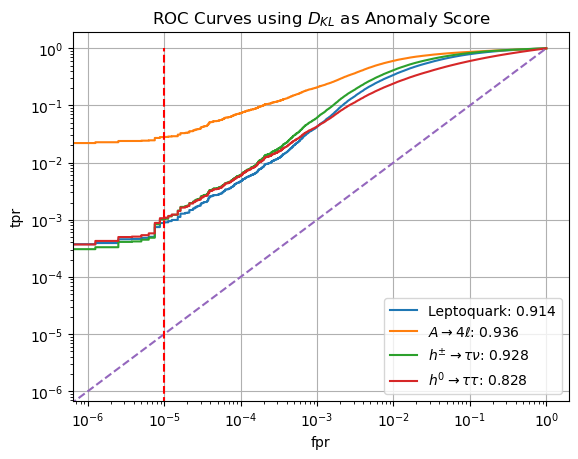

Leptoquark TPR @ FPR 10e-5 (%): 0.09
A to 4L TPR @ FPR 10e-5 (%): 2.79
h to Tau Nu TPR @ FPR 10e-5 (%): 0.10
h to Tau Tau TPR @ FPR 10e-5 (%): 0.11
10642/10642 [==============================] - 7s 611us/step


/tmp/ipykernel_93483/609871311.py:3: RuntimeWarning: overflow encountered in exp
  kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))


RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -78.59422302246094
z_log_var: 91.96759033203125
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -50.57332992553711
z_log_var: 98.87755584716797
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -55.7116584777832
z_log_var: 90.61217498779297
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -50.66350555419922
z_log_var: 92.19154357910156
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -16.000015258789062
z_log_var: 136.0682373046875
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -40.983150482177734
z_log_var: 139.13873291015625
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -27.245012283325195
z_log_var: 89.33860778808594
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -20.77002716064453
z_log_var: 89.48699188232422
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -77.09425354003906
z_log_var: 92.2744

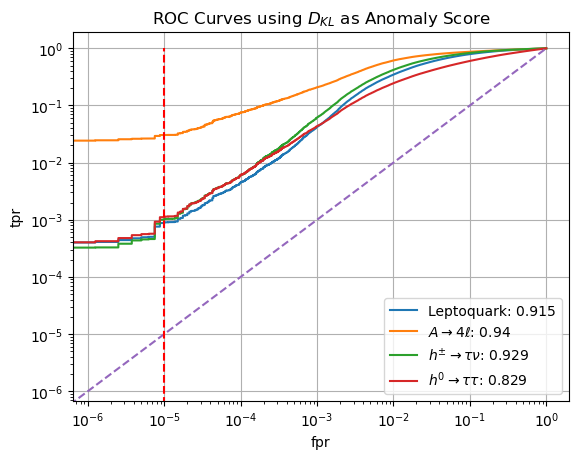

Leptoquark TPR @ FPR 10e-5 (%): 0.09
A to 4L TPR @ FPR 10e-5 (%): 3.03
h to Tau Nu TPR @ FPR 10e-5 (%): 0.10
h to Tau Tau TPR @ FPR 10e-5 (%): 0.11


In [6]:
INPUT_SZ = 57
H1_SZ = 32
H2_SZ = 16
LATENT_SZ = 3
NUM_TRAIN = 30 # number of trained models

SAVE_PATH = home_path+f"/VAE_trainings/attempt2/old_cyclical_beta/" # As of 7/10/25. should be synced with vae0_analysis
for i in range(2):
    new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
    new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
    new_VAE = VAE_Model(new_enc, new_dec)
    save_path = SAVE_PATH + f"n_{i}/"

    new_VAE.load_weights(save_path)

    just_enc = new_VAE.get_layer("encoder") # We only need encoder output
    t, s = get_truth_and_scores(just_enc, AD_score_KL)
    plot_rocs(t, s, "ROC Curves using $D_{KL}$ as Anomaly Score")

21603/21603 [==============================] - 13s 619us/step


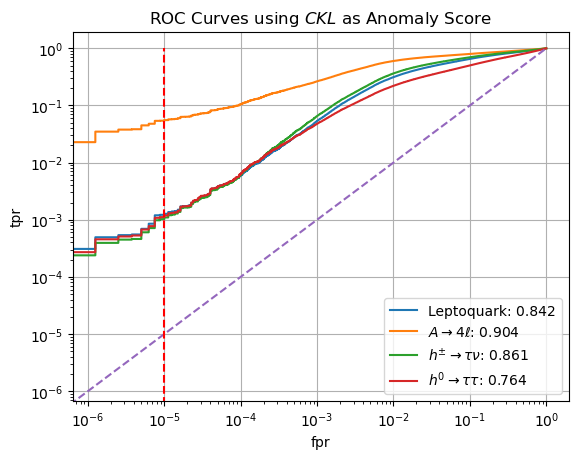

Leptoquark TPR @ FPR 10e-5 (%): 0.12
A to 4L TPR @ FPR 10e-5 (%): 5.41
h to Tau Nu TPR @ FPR 10e-5 (%): 0.10
h to Tau Tau TPR @ FPR 10e-5 (%): 0.11


In [8]:
t, s = get_truth_and_scores(just_enc, AD_score_CKL)
plot_rocs(t, s, "ROC Curves using $CKL$ as Anomaly Score")